In [165]:
from torch.utils.data import DataLoader,Dataset, Subset, random_split
from torchvision import models,transforms
import pandas as pd
import numpy as np
import os
from PIL import Image
from typing import Tuple, List
import torch

In [12]:
data_dir = '../../input/data/train'

In [147]:
class MaskDataset(Dataset):
        
        def __init__(self, data_dir: str, transforms=None, adj_csv:bool =True, val_ratio: float = 0.2):
            '''
            Agrs:
                data_dir (str): 데이터 경로
                adj_csv (bool): 데이터 경로에 라벨링 완료된 train_adj.csv 존재 여부
            
            '''
            self.data_dir = data_dir
            self.df_train = pd.read_csv(self.data_dir + '/' + 'train.csv')
            self.image_dir = self.data_dir + '/images'
            self.transforms = transforms
            self.val_ratio = val_ratio
            
            id = []
            self.gender = []
            self.age = []
            path = []
            self.mask_labels = []
            self.extension_labels = []
            
            # 정답 레이블(ans) 생성용 / decode용 dict
            self.class_dict = dict()
            self.class_dict_decode = dict()
            keys = [(i,j,k) for i in range(3) for j in range(2) for k in range(3)]
            labels = range(18)
            for x,y in zip(keys,labels):
                self.class_dict[x] = y
                self.class_dict_decode[y] = x
            
            # train_adj 없는 경우 생성, 있는 경우 불러옴
            if not adj_csv:
                for i in range(len(self.df_train)):
                    tmp = self.df_train.iloc[i]
                    id_ = tmp['id']
                    gender_ = int(tmp['gender']=='female')
                    age_ = tmp['age']
                    path1 = tmp["path"]
                    for path2 in os.listdir(self.image_dir + '/' + path1):
                        if path2.startswith("._"):
                            continue
                        name, ext = path2.split('.')
                        for k, x in enumerate(['mask','incorrect','normal']):
                            if name.startswith(x):
                                self.mask_labels.append(k)
                        self.extension.append(ext)
                        path.append(os.path.join(self.image_dir, path1 + '/' + path2))
                        id.append(id_)
                        self.gender_labels.append(gender_)
                        self.age_labels.append(age_)

                self.df_train_adj = pd.DataFrame(data = zip(id,path,extension,age,mask,gender), columns = ['id','path','extension','age','mask','gender'])
                # (30세 미만, 30세 이상 60세 미만, 60세 이상) = (0,1,2)
                self.df_train_adj['age_class'] = pd.cut(self.df_train_adj['age'], bins = [0,30,60,1000], right=False, labels = [0,1,2])                             
                # 정답 레이블 컬럼 추가
                self.df_train_adj['ans'] = [self.class_dict[tuple(self.df_train_adj[['mask','gender','age_class']].iloc[i])] for i in range(len(self.df_train_adj))] 
                self.df_train_adj.to_csv(self.data_dir + '/' + 'train_adj.csv', index = False)

                self.age_labels = list(self.df_train_adj['age_class'])
                self.image_paths = list(self.df_train_adj['path'])
                self.labels = list(self.df_train_adj['ans'])
            else:
                self.df_train_adj = pd.read_csv(self.data_dir + '/' + 'train_adj.csv')
                self.image_paths = list(self.df_train_adj['path'])
                self.labels = list(self.df_train_adj['ans'])
                self.age_labels = list(self.df_train_adj['age_class'])
                self.mask_labels = list(self.df_train_adj['mask'])
                self.gender_labels = list(self.df_train_adj['gender'])
                self.age = list(self.df_train_adj['age'])
                

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, index):
            X = np.array(Image.open(self.image_paths[index]))
            y = self.labels[index]
            if self.transforms:
                X = self.transforms(X)
                
            return X, y
        
        def get_mask_label(self, index) -> 'mask_label':
            tmp = ['Wear', 'Incorrect', 'Not Wear'][self.mask_labels[index]]
            print(f'마스크 착용 여부: {tmp}')
            return self.mask_labels[index]

        def get_gender_label(self, index) -> 'gender_label':
            tmp = ['Male', 'Female'][self.gender_labels[index]]
            print(f'성별: {tmp}')
            return self.gender_labels[index]

        def get_age_label(self, index) -> 'age_label':
            tmp = self.age[index]
            print(f'Age: {tmp}')
            return self.age_labels[index]

        def read_image(self, index) -> 'print image':
            image_path = self.image_paths[index]
            tmp = ['Wear', 'Incorrect', 'Not Wear'][self.mask_labels[index]]
            print(f'마스크 착용 여부: {tmp}')
            tmp = ['Male', 'Female'][self.gender_labels[index]]
            print(f'성별: {tmp}')
            tmp = self.age[index]
            print(f'Age: {tmp}')
            print(f'Class: {self.labels[index]}')
            return Image.open(image_path)

        def encode_multi_class(self, mask_label, gender_label, age_label) -> int:
            return self.class_dict[(mask_label,gender_label,age_label)]

        def decode_multi_class(self, multi_class_label):
            return self.class_dict_decode[multi_class_label]
        
        def split_dataset(self) -> Tuple[Subset, Subset]:
            val_ratio = self.val_ratio
            n_val = int(len(self) * val_ratio)
            n_train = len(self) - n_val
            train_set, val_set = random_split(self, [n_train, n_val])
            print(f'Data split completed: {val_ratio=}')
            print(f'{n_train=}, {n_val=}')
            return train_set, val_set

In [187]:
train_transform = transforms.Compose([transforms.ToTensor(),transforms.RandomRotation(degrees = 15),transforms.RandomVerticalFlip(p=0.5)])

In [188]:
a = MaskDataset(data_dir=data_dir,transforms=train_transform, adj_csv = True)

In [189]:
a[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 10)

마스크 착용 여부: Incorrect
성별: Female
Age: 45
Class: 10


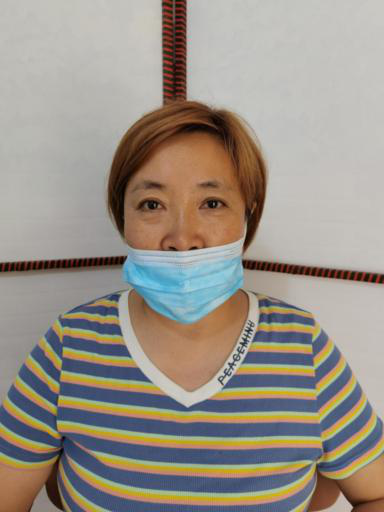

In [186]:
a.read_image(0)

In [168]:
t,v = a.split_dataset()

Data split completed: val_ratio=0.2
n_train=15120, n_val=3780


In [169]:
dataset = MaskDataset(data_dir=data_dir,transforms=train_transform, adj_csv = True)
batch_size = 64
train_set, val_set = dataset.split_dataset()
use_cuda = torch.cuda.is_available()

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=use_cuda,
    drop_last=True,
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=use_cuda,
    drop_last=True,
)

Data split completed: val_ratio=0.2
n_train=15120, n_val=3780


In [170]:
next(iter(train_loader))

[tensor([[[[0.6000, 0.6078, 0.7255,  ..., 0.6431, 0.6471, 0.6510],
           [0.6157, 0.6196, 0.7255,  ..., 0.7059, 0.7098, 0.7137],
           [0.6627, 0.6588, 0.7333,  ..., 0.6980, 0.7020, 0.7020],
           ...,
           [0.3490, 0.3725, 0.3529,  ..., 0.6196, 0.6196, 0.6196],
           [0.3412, 0.3569, 0.3412,  ..., 0.6196, 0.6196, 0.6196],
           [0.3451, 0.3569, 0.3412,  ..., 0.6196, 0.6196, 0.6196]],
 
          [[0.6039, 0.6118, 0.7294,  ..., 0.3137, 0.3176, 0.3216],
           [0.6196, 0.6235, 0.7294,  ..., 0.5098, 0.5137, 0.5176],
           [0.6667, 0.6627, 0.7373,  ..., 0.6784, 0.6824, 0.6824],
           ...,
           [0.3490, 0.3725, 0.3569,  ..., 0.6392, 0.6392, 0.6392],
           [0.3451, 0.3569, 0.3451,  ..., 0.6392, 0.6392, 0.6392],
           [0.3490, 0.3569, 0.3451,  ..., 0.6392, 0.6392, 0.6392]],
 
          [[0.5804, 0.5882, 0.7059,  ..., 0.3137, 0.3176, 0.3216],
           [0.5961, 0.6000, 0.7059,  ..., 0.4745, 0.4784, 0.4824],
           [0.6431, 0.63

In [190]:
a.decode_multi_class(10)

(1, 1, 1)